# Goal and Objective

- Use time-series forecasting, to predict the sales of  the groceries store over time and also the profit and revenue of it.


- Build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores

# Data Description

- Data provided with 6 csv files (train, test, store, oil, holidays_events, transactions)
  containing data about products, stores, promotions, sales, oil prices, holidays and more. 



- Target value: sale

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

%matplotlib inline

# Import the Data

In [24]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv")
holidays = pd.read_csv("holidays_events.csv")

# Data Understanding

### Training Data

In [27]:
print(train.shape)
train.head()

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


### Testing Data

In [28]:
print(test.shape)
test.head()

(28512, 5)


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


### Stores

In [29]:
print(stores.shape)
stores.head()

(54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### Oil

In [30]:
print(oil.shape)
oil.head()

(1218, 2)


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


### Holidays

In [31]:
print(holidays.shape)
holidays.head()

(350, 6)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


- Each row represents the sales of a specific product (‘family’)

- in a specific store (‘store_nbr’) 

- on a single day (date) from 2013 to 2017

## Check data completeness and quality

- Check the **missing and duplicated** values

In [8]:
# Check for missing values
print(train.isnull().sum())

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [6]:
print(train.duplicated().value_counts())

False    3000888
dtype: int64


- Here we Check if the time series data is comelete

- if any missing values or gap in the data --> interpolate and impute the missing values

In [9]:
# Check number of data points
print(len(train))

3000888


# EDA

## Descriptive Overview

In [10]:
round(train.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
id,3000888.0,1500443.50,866281.89,0.0,750221.75,1500443.5,2250665.25,3000887.0
store_nbr,3000888.0,27.50,15.59,1.0,14.00,27.5,41.00,54.0
sales,3000888.0,357.78,1102.00,0.0,0.00,11.0,195.85,124717.0
onpromotion,3000888.0,2.60,12.22,0.0,0.00,0.0,0.00,741.0


**Understand the data distribution**

- Plotting the time series data on a line plot can help you understand the overall trend and seasonality. 

- Create histograms and box plots to understand the distribution of the data and identify any outliers or unusual patterns.

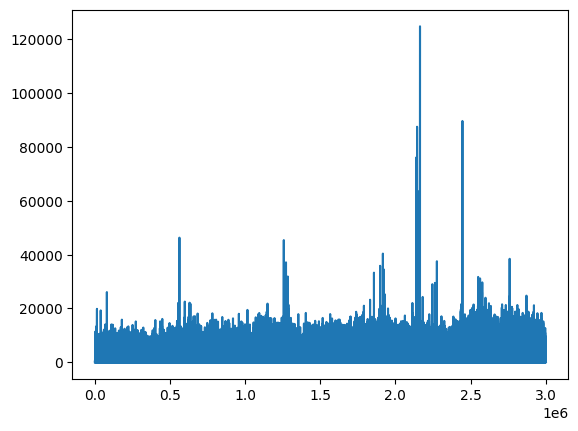

In [12]:
train['sales'].plot()
plt.show()

- check time series, convert the 'date' column to a datetime object and set it as a index

- set it as index -> easy slicing and indexing to do some operation like resampling, aggregation and etc

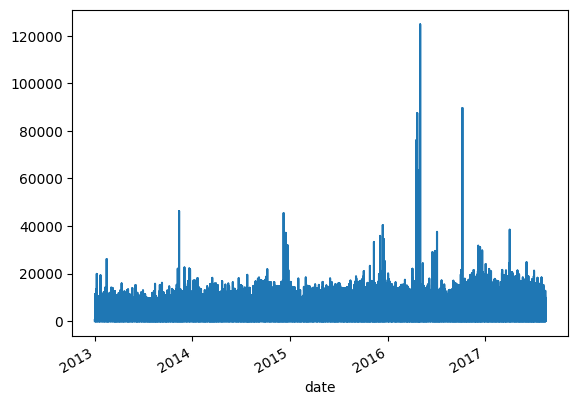

In [13]:
train['date'] = pd.to_datetime(train['date'])

train.set_index('date', inplace=True)

train['sales'].plot()
plt.show()

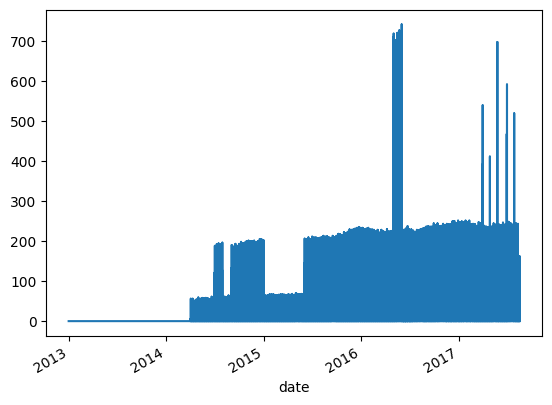

In [18]:
train['onpromotion'].plot()
plt.show()

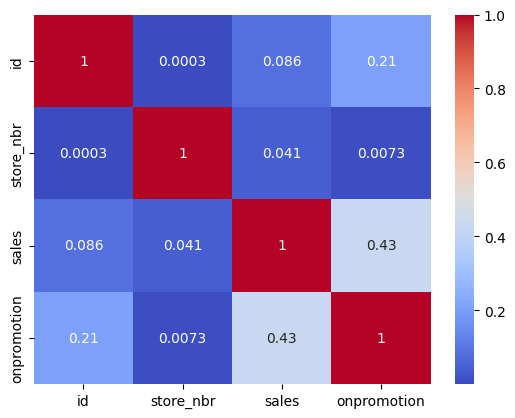

In [15]:
corr = train.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


In [ ]:
# average sales grouped by day 

average_sales = train.groupby('date')['sales'].mean()
train.groupby('date')['sales'].mean().to_frame()

- Decompose the time series data: 

- Time series data can be decomposed into its trend, seasonality, and residual components. 


- This can help you better understand the underlying patterns and identify any anomalies or irregularities in the data. 


- You can use decomposition methods like additive or multiplicative decomposition.

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

C:\Users\tmost\AppData\Local\Temp\ipykernel_25460\3452964089.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train = train.resample('D').sum() # Resample to daily frequency


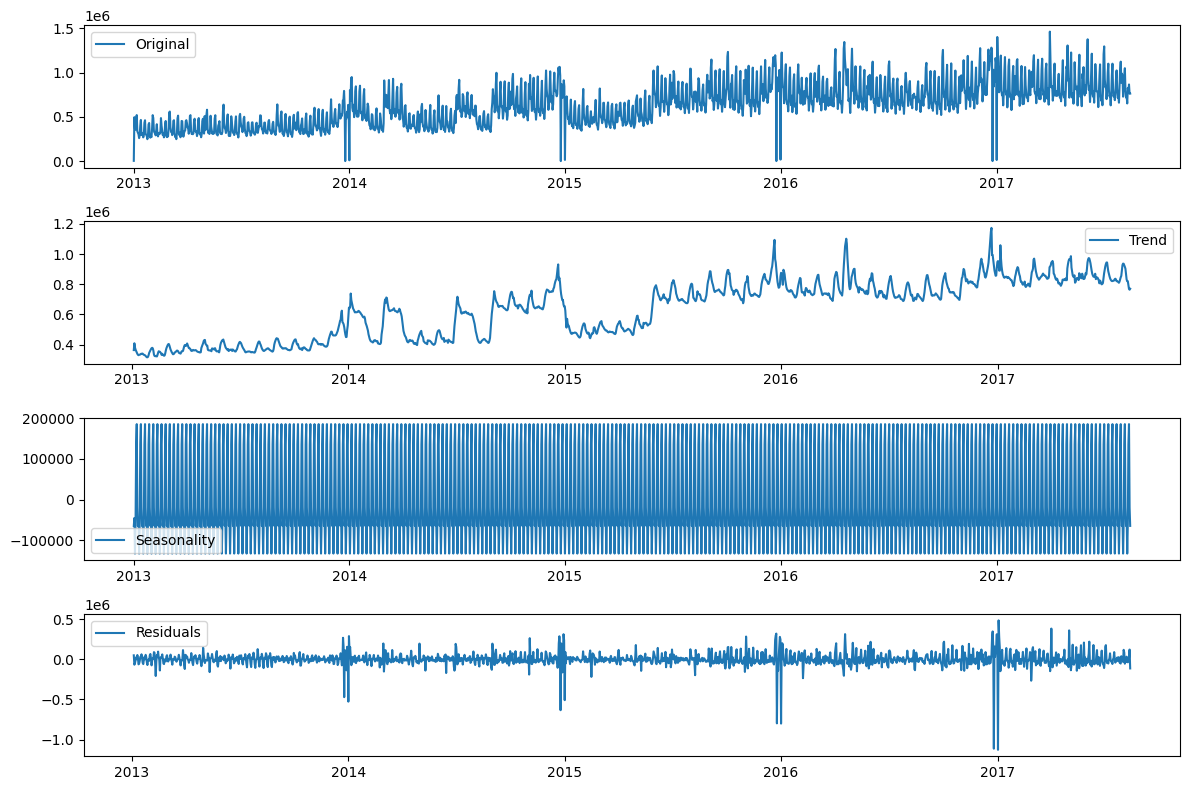

In [22]:
# Load the time series data

train = pd.read_csv('train.csv', parse_dates=['date'], index_col='date')
train = train.resample('D').sum() # Resample to daily frequency

# Decompose the time series data using additive decomposition
decomposition = seasonal_decompose(train['sales'], model='additive')


# Plot the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
axes[0].plot(train['sales'], label='Original')
axes[0].legend(loc='best')
axes[1].plot(decomposition.trend, label='Trend')
axes[1].legend(loc='best')
axes[2].plot(decomposition.seasonal,label='Seasonality')
axes[2].legend(loc='best')
axes[3].plot(decomposition.resid, label='Residuals')
axes[3].legend(loc='best')
plt.tight_layout()
plt.show()